In [121]:
from urllib import request
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.version.version

'1.15.4'

Accessing data:

In [122]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

KeyboardInterrupt: 

# Exploratory Analysis 

Check readme file

This data set consists of:
   * 100,000 ratings (1-5) from 943 users on 1682 movies. 
   * Each user has rated at least 20 movies. 

In [123]:
users_num = 943
movies_num = 1682


How our data looks?

In [124]:
df = pd.read_csv('ml-100k/u.data', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)

In [125]:
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


Check if every pair (user, item) appears only once

In [126]:
df.groupby(['user_id','item_id']).count().reset_index()['timestamp'].max()

1

In [127]:
df.duplicated(subset = ['user_id', 'item_id', 'rating']).count()

100000

Check for nan

In [128]:
df['rating'].unique()
df.isnull().sum()

user_id      0
item_id      0
rating       0
timestamp    0
dtype: int64

Ratings distribution

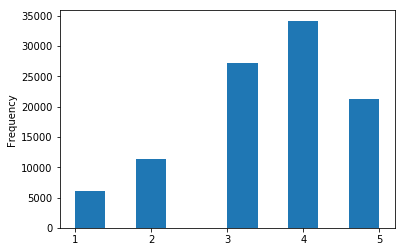

In [129]:
df['rating'].plot.hist(xticks = [1, 2, 3, 4, 5])

In [130]:
# plt.hist(df['rating'], bins=5)

Choose one movie from u.info file and check its ratings

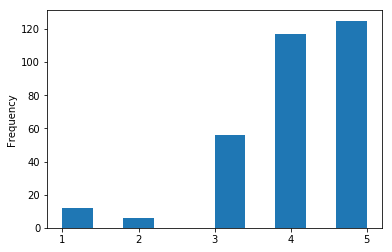

In [131]:
df[df.item_id==168]['rating'].plot.hist(xticks = [1, 2, 3, 4, 5])

#### Sparsity
calculate the number of movies each user rated

In [132]:
grouped = df[['user_id', 'item_id']].groupby('user_id').count().rename(columns = {'item_id' : 'rating_count'}).sort_values('rating_count', ascending=False)
grouped.head()

,rating_count
user_id,
405,737
655,685
13,636
450,540
276,518


In [133]:
grouped['sparsity'] = 1.0 - grouped.rating_count / float(movies_num)
grouped.head()

,rating_count,sparsity
user_id,,
405,737,0.561831
655,685,0.592747
13,636,0.621879
450,540,0.678954
276,518,0.692033


In [134]:
np.average(grouped['sparsity'])

0.9369533063577546

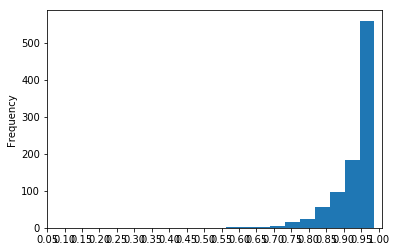

In [135]:
grouped['sparsity'].plot.hist(xticks = [i*0.05 for i in range(1,21)])

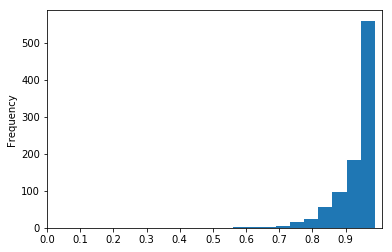

In [136]:
grouped['sparsity'].plot.hist(xticks = [i*0.1 for i in range(10)])

Reindex ids to numpy's like

In [137]:
[(df[x].min(),df[x].max()) for  x in ['user_id', 'item_id']]

[(1, 943), (1, 1682)]

In [138]:
for col in  ['user_id', 'item_id']:
    df[col] = df[col]-1

In [139]:
[(df[x].min(),df[x].max()) for  x in ['user_id', 'item_id']]

[(0, 942), (0, 1681)]

# User-User CF

Firstly we want to have our data in form of matrix, where rows coresponds to users, columns to items and values to ratings

In [140]:
ratings_matrix = np.matrix(df.pivot(index = 'user_id', columns = 'item_id', values = 'rating').fillna(0).values)
ratings_matrix

matrix([[5., 3., 4., ..., 0., 0., 0.],
        [4., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [5., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 5., 0., ..., 0., 0., 0.]])

Similarity functions:
* cosine similarity
* Pearson correlation

In [141]:
def cosine_similarity_distance(M):
# insert your code here ~ 8-10 lines
    n,k = M.shape
    distance_matrix = np.matrix(np.zeros(n*n))
    distance_matrix.shape = (n, n)
    for a in range(n):
        for b in range(n):
            vec_sum = float(np.count_nonzero(M[a].A1+M[b].A1))
            if vec_sum == 0:
                distance_matrix[a,b] = 1
            else:
                distance_matrix[a,b] = 1 - np.count_nonzero(M[a].A1 * M[b].A1) / vec_sum
            
    return distance_matrix # n x n matrix, where M is n x k matrix

In [142]:
distance_matrix = cosine_similarity_distance(ratings_matrix)

In [143]:
distance_matrix

matrix([[0.        , 0.94303797, 0.97484277, ..., 0.96478873, 0.91666667,
         0.767507  ],
        [0.94303797, 0.        , 0.91588785, ..., 0.90909091, 0.90697674,
         0.95927602],
        [0.97484277, 0.91588785, 0.        , ..., 0.94444444, 0.92741935,
         0.99090909],
        ...,
        [0.96478873, 0.90909091, 0.94444444, ..., 0.        , 0.95876289,
         0.97297297],
        [0.91666667, 0.90697674, 0.92741935, ..., 0.95876289, 0.        ,
         0.91666667],
        [0.767507  , 0.95927602, 0.99090909, ..., 0.97297297, 0.91666667,
         0.        ]])

In [144]:
from scipy.stats.stats import pearsonr

def scipy_pearson_similarity_distance(M):
# insert your code here ~ 8-10 lines
    n,k = M.shape
    distance_matrix = np.matrix(np.zeros(n*n))
    distance_matrix.shape = (n, n)
    for a in range(n):
        for b in range(n):
            vec_sum = float(np.count_nonzero(M[a].A1+M[b].A1))
            if vec_sum == 0:
                distance_matrix[a,b] = 1
            else:
                distance_matrix[a,b] = 1 - pearsonr(M[a].A1, M[b].A1)[0]
    return distance_matrix # n x n matrix, where M is n x k matrix

In [145]:
distance_matrix_pearson = scipy_pearson_similarity_distance(ratings_matrix)
distance_matrix_pearson

matrix([[0.        , 0.89367807, 1.01642393, ..., 0.8844965 , 0.89101633,
         0.67676922],
        [0.89367807, 0.        , 0.91731983, ..., 0.85582336, 0.86170755,
         0.94576474],
        [1.01642393, 0.91731983, 0.        , ..., 0.91546805, 0.89797522,
         1.02360053],
        ...,
        [0.8844965 , 0.85582336, 0.91546805, ..., 0.        , 0.91987038,
         0.93470037],
        [0.89101633, 0.86170755, 0.89797522, ..., 0.91987038, 0.        ,
         0.87226457],
        [0.67676922, 0.94576474, 1.02360053, ..., 0.93470037, 0.87226457,
         0.        ]])

k- nearest neighboors

In [146]:
def knn(ratings_matrix, k, similarity_function):
    #insert your code here ~ 3 lines
    dist_matrix = similarity_function(ratings_matrix) # obliczamy macierz odległości
    idx = np.argsort(dist_matrix)[:,1:k+1] # sortujemy każdy wiersz
    # na pierwszym miejscu zawsze jest user sam do siebie, bo jest najbliżej
    sorted_dist = np.take_along_axis(dist_matrix, idx, axis = 1)
    return idx, sorted_dist # two n x k matrix

In [147]:
# let's test it
neighbors, neighbors_dist = knn(ratings_matrix, 3, cosine_similarity_distance)
neighbors

matrix([[915,  91, 267],
        [700, 459, 930],
        [615, 528, 586],
        ...,
        [688, 816, 741],
        [262,  90, 487],
        [932, 773, 471]])

In [148]:
neighbors_dist

matrix([[0.64285714, 0.65580448, 0.65771812],
        [0.66197183, 0.67346939, 0.69148936],
        [0.65277778, 0.67123288, 0.67826087],
        ...,
        [0.68181818, 0.71111111, 0.73684211],
        [0.74534161, 0.76223776, 0.78645833],
        [0.66159696, 0.67118644, 0.67384615]])

In [149]:
def calculate_recommendation(ratings_matrix, neighbors, distances):
     #insert your code here ~ 8-12 lines
    u,k = neighbors.shape
    p = ratings_matrix.shape[1]
    recommendation_matrix = np.matrix(np.zeros(u*p))
    recommendation_matrix.shape = (u,p)
    for i in range(u):
        for j in range(p):
            numerator = np.sum((1-distances[i, :].A1) * ratings_matrix[neighbors[i],j].A1)
            denominator = np.sum(1 - distances[i,:].A1) # similarity = 1 - distance
            if denominator == 0:
                recommendation_matrix[i,j] = 0
            else:
                recommendation_matrix[i,j] = numerator / float(denominator)
    return recommendation_matrix # same shape as ratings_matrix filled with our prediction

In [150]:
recommendation_matrix = calculate_recommendation(ratings_matrix, neighbors, neighbors_dist)

In [151]:
recommendation_matrix
# niektóre wartości są zerami, bo mamy bardzo mały zasięg sąsiedztwa (3) - niektórzy nasi sąsiedzi nie widzieli
# jeszcze filmów, więc nie możemy ich ocenić.

matrix([[3.6720245 , 2.6720245 , 1.35462151, ..., 0.        , 0.        ,
         1.02664601],
        [2.06066891, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [3.63436985, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [2.7110753 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [2.66363708, 1.97266065, 1.64165265, ..., 0.        , 0.        ,
         0.        ]])

We need indicator for existing ratings

In [152]:
rating_ind = np.matrix(ratings_matrix != 0, dtype=float)
rating_ind

matrix([[1., 1., 1., ..., 0., 0., 0.],
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [1., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 1., 0., ..., 0., 0., 0.]])

In [153]:
def get_recommendation(recommendation_matrix, rating_ind, n):
    # insert your code here ~ 2 lines
    X = np.multiply(recommendation_matrix, 1-rating_ind) # mnozymy razy odwrotność macieszy rating_ind -chcemy tylko rekomendacje dla tych filmów, które nie mają jeszcze ratingu
    recommendation = np.argsort(-X)[:, :n] # sortujemy rekomendacje i wybieramy pierwsze n. sorty zawsze jest rosnący, dlatego -X
    ratings = np.take_along_axis(recommendation_matrix, recommendation, axis = 1)
    return recommendation, ratings # n recommendations for every user and estimated ratings


In [154]:
recommendation, est_ratings = get_recommendation(recommendation_matrix, rating_ind, 5)
recommendation

matrix([[ 581,  424,  474, 1072,  473],
        [ 749,  514,  123,  689,  136],
        [ 285,  291,  312,  268,  300],
        ...,
        [ 747,  327,   49,  404,  120],
        [ 175,   68,   21,  514,  204],
        [ 182,  176,  174,  175,  134]])

In [155]:
est_ratings

matrix([[4.65778466, 4.34221534, 4.32980916, 4.32980916, 4.3279755 ],
        [3.32216178, 3.26308297, 3.0791876 , 2.65772943, 2.62898507],
        [4.34801274, 3.67752837, 3.35242187, 3.34801274, 3.32951563],
        ...,
        [3.15602664, 3.15602664, 3.03775429, 2.82405767, 2.82405767],
        [4.69751689, 4.69751689, 4.69751689, 4.69751689, 4.69751689],
        [4.32833053, 4.        , 3.99732254, 3.98766906, 3.66899201]])

# Item-Item CF

neighbors i distance muszą być teraz dla Items a nie users. Trzeba zrobić transpozycję tablicy ratingów, albo zmienić pivot (zamienić index i columns)

What we have to change?

In [156]:
ratings_item_matrix = np.matrix(df.pivot(index = 'item_id', columns = 'user_id', values = 'rating').fillna(0).values)
ratings_item_matrix

matrix([[5., 4., 0., ..., 5., 0., 0.],
        [3., 0., 0., ..., 0., 0., 5.],
        [4., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [157]:
def calculate_recommendation_item_based(ratings_matrix, item_neighbors, item_distances):
    #insert your code here ~ 8-12 lines (most code can be pasted from previous calculate_recommendation)
    p,k = item_neighbors.shape
    u = ratings_matrix.shape[0]
    recommendation_matrix = np.matrix(np.zeros(u*p))
    recommendation_matrix.shape = (u,p)
    for i in range(u):
        for j in range(p):
            numerator = np.sum((1-item_distances[i, :].A1) * ratings_matrix[item_neighbors[i],j].A1)
            denominator = np.sum(1 - item_distances[i,:].A1) # similarity = 1 - distance
            if denominator == 0:
                recommendation_matrix[i,j] = 0
            else:
                recommendation_matrix[i,j] = numerator / float(denominator)
    
    return recommendation_matrix

In [158]:
item_neighbors, item_distances = knn(ratings_item_matrix, 3, cosine_similarity_distance)
item_neighbors

matrix([[  49,  120,  180],
        [ 232,  230,  402],
        [  16,  122,  824],
        ...,
        [1678, 1677, 1606],
        [1671, 1621, 1350],
        [1596, 1267,  766]])

# Testing

In [159]:
train_1 = pd.read_csv('ml-100k/u1.base', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)
test_1 = pd.read_csv('ml-100k/u1.test', header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                 delim_whitespace=True)

In [160]:
for col in  ['user_id', 'item_id']:
    train_1[col] = train_1[col]-1
    test_1[col] = test_1[col]-1

In [161]:
train_1_ratings_matrix = np.matrix(pd.crosstab(index=pd.Categorical(train_1['user_id'],categories = [i for i in range(943)]), 
                              columns=pd.Categorical(train_1['item_id'],categories = [i for i in range(1682)]),
                             values=train_1['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
test_1_ratings_matrix = np.matrix(pd.crosstab(index=pd.Categorical(test_1['user_id'],categories = [i for i in range(943)]), 
                              columns=pd.Categorical(test_1['item_id'],categories = [i for i in range(1682)]),
                             values=test_1['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)

In [162]:
train_1_if_filled = np.matrix(train_1_ratings_matrix != 0, dtype = float)
test_1_if_filled = np.matrix(test_1_ratings_matrix != 0, dtype = float)

Check if train + test is equal to full data_set

In [163]:
np.all(train_1_if_filled + test_1_if_filled == (ratings_matrix != 0))

True

In [164]:
neighbors, distances = knn(train_1_ratings_matrix, 3, cosine_similarity_distance)

In [165]:
recommendation_matrix = calculate_recommendation(train_1_ratings_matrix, neighbors, distances)

In [171]:
recommendation_matrix

matrix([[4.63885509, 0.95450257, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [2.99391156, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [3.63436985, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [1.0624797 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [2.66363708, 1.97266065, 1.64165265, ..., 0.        , 0.        ,
         0.        ]])

### RMSE

In [166]:
# teraz obliczymy MSE, na ile się pomyliliśmy jeśli chodzi o rekomendacje
def rmse(ratings_matrix,recommendation_matrix, test_ind):
    #insert your code here ~ 2-4 lines
    X = np.multiply((ratings_matrix - recommendation_matrix), test_ind)
    Y = np.sum(np.multiply(X,X))
    Z = np.sum(test_ind)
    output = np.sqrt(Y/Z)
    return output
    

In [170]:
X = rmse(ratings_matrix, recommendation_matrix, test_1_if_filled)
X

2.692115220907426

# Validation

In [168]:
def cross_val_testing(ratings_matrix):
    results =[]
    for i in range(1,6):
        if(i!=5):
            continue
        train = pd.read_csv('ml-100k/u{}.base'.format(i), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)
        test = pd.read_csv('ml-100k/u{}.test'.format(i), header=None, names=['user_id', 'item_id', 'rating', 'timestamp'], 
                             delim_whitespace=True)

        for col in  ['user_id', 'item_id']:
            train[col] = train[col]-1
            test[col] = test[col]-1
        
        train_ratings_matrix = np.matrix(pd.crosstab(index=pd.Categorical(train['user_id'],categories = [i for i in range(943)]), 
                                                    columns=pd.Categorical(train['item_id'],categories = [i for i in range(1682)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
        test_ratings_matrix = np.matrix(pd.crosstab(index=pd.Categorical(test['user_id'],categories = [i for i in range(943)]), 
                                                    columns=pd.Categorical(test['item_id'],categories = [i for i in range(1682)]),
                                                    values=test['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)
        
        train_ratings_item_matrix = np.matrix(pd.crosstab(index=pd.Categorical(train['item_id'],categories = [i for i in range(1682)]), 
                                                    columns=pd.Categorical(train['user_id'],categories = [i for i in range(943)]),
                                                    values=train['rating'], aggfunc=np.sum, dropna= False).fillna(0).values)       
        
        train_ind = np.matrix(train_ratings_matrix!=0, dtype=float)
        test_ind = np.matrix(test_ratings_matrix!=0, dtype=float)
        

        
        for function_name,dist_function in zip(['cosine','pearson'],[cosine_similarity_distance, scipy_pearson_similarity_distance]):
            for k in [3,7]:
                for cf_type,rec_fun in zip(['u-u','i-i'],[calculate_recommendation, calculate_recommendation_item_based]):                       
                    neighbors, distances = knn(train_ratings_matrix, k, dist_function) if cf_type =='u-u' \
                                           else knn(train_ratings_item_matrix, k, dist_function)
                    recommendation_matrix = rec_fun(train_ratings_matrix, neighbors, distances)
                    rmse_val = rmse(ratings_matrix, recommendation_matrix, test_ind)
                    results.append([i,cf_type,function_name,k, rmse_val])
                    print ([i,cf_type,function_name,k, rmse_val])
        
        
    return results

In [169]:
result = cross_val_testing(ratings_matrix)

[5, 'u-u', 'cosine', 3, 2.6776087486622866]


IndexError: index 957 is out of bounds for axis 0 with size 943

In [ ]:
result